In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pandas as pd
from planet_cookbook import read_reports as rr
import os
from scipy.stats import norm
from astropy import units as u

au = 1.496e+13 #cm
M_sun = 1.989e+33 #g

In [2]:
params = {
   'axes.labelsize': 20,
   'font.size': 20,
   'legend.fontsize': 10,
   'xtick.labelsize': 20,
   'ytick.labelsize': 15,
   #'text.usetex': True, #to use TeX in your labels
   'font.family':'serif',
   'axes.titlesize': 15
   }
rcParams.update(params)

In [73]:
"""
Here I use Inverse CDF sampling to sample semi-major axes from a certain surface density
distribution. I did the calculations with pen and paper, might be worth double checking.
"""
def sample_r_power_law(alpha, r_min, r_max):
    """
    Sample a value r from a power-law distribution between r_min and r_max.
    pdf = r^(-alpha)
    Parameters:
        alpha (float): Power-law exponent.
        r_min (float): Minimum value of r.
        r_max (float): Maximum value of r.

    Returns:
        float: Randomly sampled r following the power-law distribution.
    """
    u = np.random.uniform(low=0, high=1)
    r = ((r_max**(1-alpha) - r_min**(1-alpha)) * u + r_min**(1-alpha))**(1/(1-alpha))
    return r

def sample_r_linear(r_min, r_max):
    """
    Sample a value r from a distribution uniform in log(r) between r_min and r_max.

    Parameters:
        r_min (float): Minimum value of r.
        r_max (float): Maximum value of r.

    Returns:
        float: Randomly sampled r, uniform in log-space.
    """
    u = np.random.uniform(low=0, high=1)
    r = r_min * (r_max/r_min)**u
    return r

In [70]:
#Function to derive cumulative disk mass at each point where a body exists
def disk_mass_array(semis_emb, semis_pl, m_pl, m_emb):
    more_emb = np.repeat(semis_emb, 10)
    semis_sorted = np.concatenate((semis_pl, more_emb))
    semis_sorted = np.sort(semis_sorted)

    disk_mass = np.zeros(len(semis_sorted))
    for i in range(len(semis_sorted)):
        disk_mass[i] = i * m_pl
    
    return semis_sorted, disk_mass

def disk_mass_array_single(semis, m):
    semis_sorted = np.sort(semis)
    disk_mass = np.zeros(len(semis_sorted))
    for i in range(len(semis_sorted)):
        disk_mass[i] = i * m
    
    return semis_sorted, disk_mass

#Function to get total mass in the disk, using a surface density profile
def total_disk_mass(C, a, alpha, r1, r2):
    total_mass = (2 * np.pi * C / (a * au)**alpha) * (1/(alpha + 2)) * ((r2*au)**(alpha+2) - (r1*au)**(alpha+2))
    total_mass_solmass = total_mass/M_sun
    return total_mass_solmass

In [71]:
def disk_mass_array(semis, masses):
    """
    Calculate the cumulative disk mass at each sorted semi-major axis, 
    allowing for a different mass at each location.

    Parameters:
        semis (array-like): Semi-major axes.
        masses (array-like): Masses corresponding to each semi-major axis.

    Returns:
        tuple: (sorted semi-major axes, cumulative disk mass array)
    """
    # Sort semi-major axes and reorder masses accordingly
    sort_idx = np.argsort(semis)
    semis_sorted = np.array(semis)[sort_idx]
    masses_sorted = np.array(masses)[sort_idx]
    # Cumulative sum of masses (excluding the current body, like original)
    disk_mass = np.concatenate([[0], np.cumsum(masses_sorted)[:-1]])
    return semis_sorted, disk_mass


def total_disk_mass(C, a, alpha, r1, r2):
    """
    Calculate the total mass with the surface density distribution of
    Sigma = C (g/cm^2) * (r/a (AU))^(alpha) (eq. 1)
    within an annulus with inner radius r1 and outer radius r2.
    This total mass is the integral of SigmadA from r1 to r2.
    Parameters:
        C (float): coefficient C in eq.1, units of g/cm^2
        a (float): normalization factor a in eq. 1, units of AU
        alpha (float): power in eq. 1
        r1 (float): inner disk radius, units of AU
        r2 (float): outer disk radius, units of AU

    Returns:
        total_mass_solmass (float): total disk mass in units of solarMass
    """
    total_mass = (2 * np.pi * C / (a * au)**alpha) * (1/(alpha + 2)) * ((r2*au)**(alpha+2) - (r1*au)**(alpha+2))
    total_mass_solmass = total_mass/M_sun
    return total_mass_solmass

In general, with a surface density distribution the form of:

$\sigma = C (\frac{g}{cm^2})(\frac{r}{a (AU)})^\alpha$

You can get the whole disk mass with the function total_disk_mass, and then divide it by your number of bodies to get your planetesimal mass.

In [78]:
#Chambers 2013 mass and edges
m_tot_cham = 2.604 * u.M_earth.to(u.solMass)
r_in_cham = 0.3 #AU
r_out_cham = 2 #AU

n = 10**4

m_pl = m_tot_cham/n #solMass

In [79]:
#You can decide what mass you would want inside the disk, and what mass outside
#My hand calculations were 2*2.8e-7 + 24*2.8e-8 solMass inside, and the rest outside

m_inside = 2 * 2.8e-7 + 24 * 2.8e-8 #solMass
m_outside = m_tot_cham - m_inside

n_inside = int(m_inside/m_pl)
print("number of bodies inside linear regime = ", n_inside)
n_outside = int(m_outside/m_pl)
print("number of bodies in the power-law regime = ", n_outside)

number of bodies inside linear regime =  1575
number of bodies in the power-law regime =  8424


In [80]:
#Sampling semi-major axes from Chambers distribution
#Linear from 0.3 to 0.7 AU, and power law with alpha = -1.5 from 0.7 to 2 AU
as_inner_cham = np.zeros(n_inside)
for i in range(len(as_inner_cham)):
    as_inner_cham[i] = sample_r_linear(0.3, 0.7)

as_outer_cham = np.zeros(n_outside)
for i in range(len(as_outer_cham)):
    as_outer_cham[i] = sample_r_power_law(1.5, 0.7, 2)

In [81]:
def compute_surface_density(semi_major_axes, m, bins=None, label=None):
    """
    Compute surface density for an array of semi-major axes.

    Parameters
    ----------
    semi_major_axes : array-like
        Semi-major axis values. (AU)
    m : float
        Mass of each object. (g)
    bins : array-like
        bin edges. If None, defaults to np.logspace(-1, 1.001, 50)
    label : str
        Label for plotting.

    Returns
    -------
    bin_centers : np.ndarray
        Centers of the bins.
    sigma : np.ndarray
        Surface density in each bin.
    """
    if bins is None:
        bins = np.logspace(-1, 1.001, 50)
    
    counts, edges = np.histogram(semi_major_axes, bins=bins)
    r1, r2 = edges[:-1], edges[1:]
    areas = np.pi * (r2**2 - r1**2) * u.AU**2
    areas = areas.to(u.cm**2)
    sigma = counts * m / areas
    bin_centers = 0.5 * (r1 + r2)
    
    return bin_centers, sigma


In [82]:
all_as = np.concatenate((as_inner_cham, as_outer_cham))

bins_chambers, sigmas_chambers = compute_surface_density(all_as, m_pl * u.solMass.to(u.g), bins = np.linspace(0.3,2.1,20))

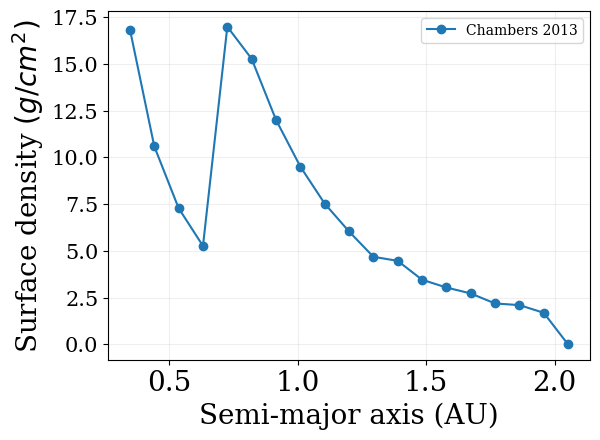

In [83]:
plt.plot(bins_chambers, sigmas_chambers , marker='o', label='Chambers 2013')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel('Semi-major axis (AU)')
plt.ylabel(r'Surface density $(g/cm^2)$')
plt.grid('True', alpha = 0.2)
plt.tight_layout()
plt.savefig('sigmas_cham_2013.pdf')
plt.show()

In [104]:
#For Ueda et al. 2021
#Log-normal distribution


median = 0.78            # desired center (median)
sigma = 0.25             # standard deviation in log-space
mu = np.log(median)      # convert median to mu

# Step 1: Generate n uniform samples
n = 10**4
uniforms = np.random.uniform(0, 1, n)

# Step 2: Inverse CDF sampling from LogNormal
as_ueda = np.exp(mu + sigma * norm.ppf(uniforms))  # norm.ppf = inverse CDF of normal
m_pl_g = m_pl * u.solMass.to(u.g)
bins_ueda, sigmas_ueda = compute_surface_density(as_ueda, m_pl_g)

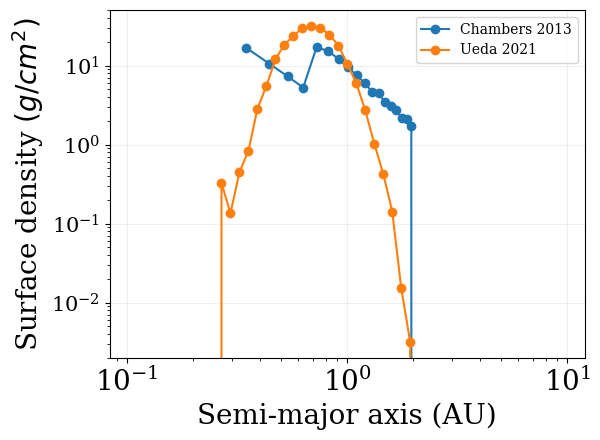

In [105]:
plt.plot(bins_chambers, sigmas_chambers , marker='o', label='Chambers 2013')
plt.plot(bins_ueda, sigmas_ueda, marker='o', label = 'Ueda 2021')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Semi-major axis (AU)')
plt.ylabel(r'Surface density $(g/cm^2)$')
plt.grid('True', alpha = 0.2)
plt.tight_layout()
plt.savefig('sigmas_cham_2013.pdf')
plt.show()